# Hypothesis: 
## We Can We Predict How Popular "Shower Thoughts" Will Be?

reddit.com is the self proclaimed "Front Page of the Internet" It aggrigates user found and generated content and displays it for comment and discussion. Users upvote or downvote content giving to or taking from the user *karma*. 

reddit.com/r/showerthoughts is a popular subreddit where users show post random yet 'deep' thoughts that they ostensibly had in the shower or while their mind was wandering. 

I attempt to scrape these thoughts and perform an NLP analysis to try and learn what makes a popular and unpopular post. 


### N.B.
Due to the internet being a horrible place, there may be some unsaviory content in this analysis. It was selected at random and I made no effort to clean the content. 

The first step is to register for a [praw](https://praw.readthedocs.io/en/latest/getting_started/authentication.html) account. 

In [1]:
import pymongo
from pymongo import MongoClient
import pandas as pd
import datetime as dt
import numpy as np
import bokeh


### Import the Scrapped Data
The code for scraping data can be found on github:

In [2]:
client = MongoClient()
db = client.thoughts_db
collection = db.thoughts_collection
cursor = db.thoughts_db.find()
df = pd.DataFrame(list(cursor))
df.head()

,_id,created_utc,score,title
0,7aswd9,1.509825e+09,5,Napkins are reverse toilet paper
1,7asvxm,1.509825e+09,2,"Evolution of Squirrels, etc..."
2,7asvjf,1.509825e+09,1,One day enough time will have passed that we k...
3,7asvi3,1.509825e+09,1,"Why do we drink, drinks yet we eat food."
4,7asuwi,1.509825e+09,0,Kevin Spacey's personality is starting to look...


In [3]:
len(df)

23112

That is an ok number of entries. More is always better and that can be achived by increasing the Unix Epoch time frame (found in the scraping code). 

The next order of business is to create dummy variables for hour of day and day of week.

In [4]:
df['DateTime'] = pd.to_datetime(df['created_utc'], unit='s') # Create human readable time.
df['Date'] = df['DateTime'].dt.date
df['Time'] = df['DateTime'].dt.hour
del df['DateTime']
df['Date'] = pd.to_datetime(df['Date'])
df['DoW'] = df['Date'].dt.weekday_name
#Day of week
df1 = pd.get_dummies(df['DoW'], drop_first=True) 
df = pd.concat([df, df1], axis = 1)
# Hour of day
df1 = pd.get_dummies(df['Time'], drop_first=True) 
df = pd.concat([df, df1], axis = 1)
del df['Date']

#df = df.join(pd.get_dummies(df['DateTime'].get_level_values(0).weekday_name))

In [5]:
df.head()

,_id,created_utc,score,title,Time,DoW,Monday,Saturday,Sunday,Thursday,...,14,15,16,17,18,19,20,21,22,23
0,7aswd9,1.509825e+09,5,Napkins are reverse toilet paper,19,Saturday,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,7asvxm,1.509825e+09,2,"Evolution of Squirrels, etc...",19,Saturday,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,7asvjf,1.509825e+09,1,One day enough time will have passed that we k...,19,Saturday,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,7asvi3,1.509825e+09,1,"Why do we drink, drinks yet we eat food.",19,Saturday,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,7asuwi,1.509825e+09,0,Kevin Spacey's personality is starting to look...,19,Saturday,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [6]:
graph = df.groupby(['DoW'])['score'].mean().reset_index()
graph.columns = ['DoW','Karma']
graph.head()

,DoW,Karma
0,Friday,84.325764
1,Monday,143.310066
2,Saturday,110.169336
3,Sunday,130.179147
4,Thursday,101.483415


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

[<matplotlib.text.Text at 0x10ed0a438>, <matplotlib.text.Text at 0x10ed242e8>]

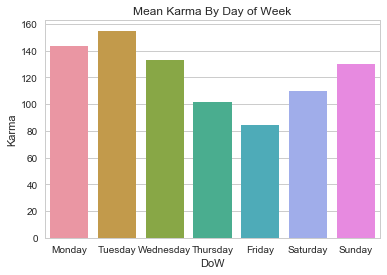

In [8]:
sns.set_style("whitegrid")
ax = sns.barplot(x = 'DoW', y = 'Karma', data=graph, order = ['Monday', 
                                                                'Tuesday', 
                                                                'Wednesday',
                                                                'Thursday', 
                                                                'Friday', 
                                                                'Saturday',
                                                               'Sunday'])
ax.set(ylabel= 'Karma', title = 'Mean Karma By Day of Week')

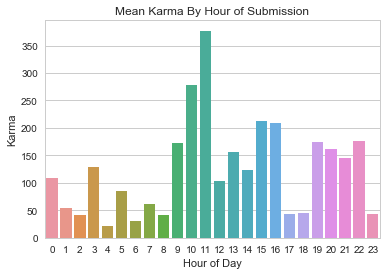

In [9]:
graph = df.groupby(['Time'])['score'].mean().reset_index()
graph.columns = ['Time','Karma']
sns.set_style("whitegrid")
ax = sns.barplot(x = 'Time', y = 'Karma', data=graph)
ax.set(xlabel='Hour of Day', ylabel= 'Karma', title = 'Mean Karma By Hour of Submission')

We can see that there is considerable variability in the amounts of karma generated from each DoW and hour. 
Unfortunetly, this analysis will not look at the interaction between DoW and Hour. This justifies our creation of dummy variables earlier.

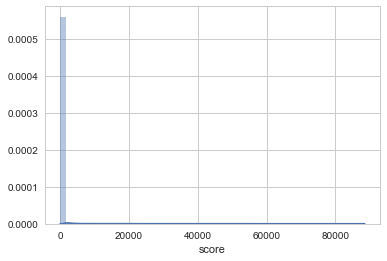

In [10]:
x = df['score']
sns.distplot(x);

In [11]:
df['score'].min()

0

In [12]:
df['score'].max()

88533

In [13]:
df.score.quantile([0, .25, .5, .75, .9, .95, 1])

0.00        0.00
0.25        1.00
0.50        3.00
0.75        7.00
0.90       29.00
0.95       86.45
1.00    88533.00
Name: score, dtype: float64

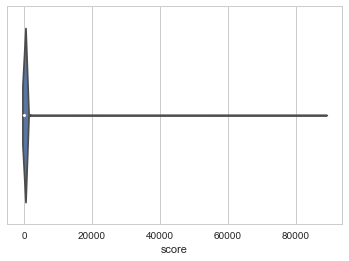

In [14]:
ax = sns.violinplot(x=x)

This is a bit of an issue as we don't have a ballanced dataset. Still, let's try do do some work

In [15]:
from collections import Counter
data = Counter(df['score'])
  # Returns all unique items and their counts
data.most_common(1)  # Returns the highest occurring item

[(0, 4289)]

Zero is obviously the most common score.

In [16]:
len(data.most_common())

768

There are 768 unique scores in the list.

In [17]:
import scipy as sp

In [18]:
df['LogScore'] = np.log(df.score + 1) # 

I took the ```ln(x)+1``` for each data point to normalize dthe data. This gives a slight bias but I think we will survive. 

In [19]:
df.LogScore.max()

11.391141938008436

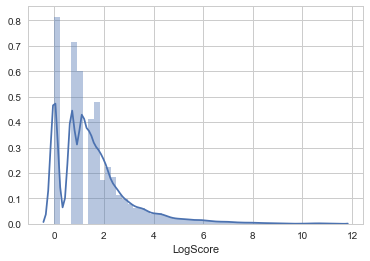

In [20]:
x = df.LogScore
sns.distplot(x);

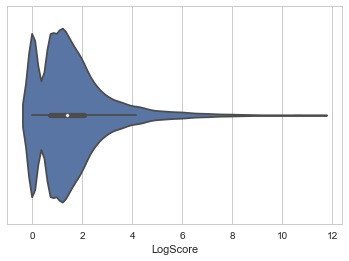

In [21]:
ax = sns.violinplot(x=x)

I love taking the log of weird datasets, suddenly, this becomes far more manigable. 


In [22]:
df.LogScore.quantile([0, .25, .5, .75, .9, .95, 1])

0.00     0.000000
0.25     0.693147
0.50     1.386294
0.75     2.079442
0.90     3.401197
0.95     4.471051
1.00    11.391142
Name: LogScore, dtype: float64

# Clasification Groups
We have to clasify these into groups as a regression analysis on words would be too difficult due to loss of degrees of freedom. This is a bit of an arbitrary cut off but heck, who cares. I will divide them into two groups:

1. Poor performers:
    * (0 , 1.386294] 0% - 49%
2. Average Performers:
    * (1.386294, 3.401197] 50% - 89%
3. High Performers:
    * (3.401197, $\infty$] 90% - 100%
    
    
%%latex

In [23]:
df['Class'] = 0
df.loc[df['LogScore'] < 1.386294, 'Class'] = 'Low'
df.loc[(df['LogScore'] >= 1.386294) & (df['LogScore'] < 3.401197), 'Class'] = 'Medium'
df.loc[df['LogScore'] >= 3.401197, 'Class'] = 'High'

In [24]:
#del df['Date']
df.head()

,_id,created_utc,score,title,Time,DoW,Monday,Saturday,Sunday,Thursday,...,16,17,18,19,20,21,22,23,LogScore,Class
0,7aswd9,1.509825e+09,5,Napkins are reverse toilet paper,19,Saturday,0,1,0,0,...,0,0,0,1,0,0,0,0,1.791759,Medium
1,7asvxm,1.509825e+09,2,"Evolution of Squirrels, etc...",19,Saturday,0,1,0,0,...,0,0,0,1,0,0,0,0,1.098612,Low
2,7asvjf,1.509825e+09,1,One day enough time will have passed that we k...,19,Saturday,0,1,0,0,...,0,0,0,1,0,0,0,0,0.693147,Low
3,7asvi3,1.509825e+09,1,"Why do we drink, drinks yet we eat food.",19,Saturday,0,1,0,0,...,0,0,0,1,0,0,0,0,0.693147,Low
4,7asuwi,1.509825e+09,0,Kevin Spacey's personality is starting to look...,19,Saturday,0,1,0,0,...,0,0,0,1,0,0,0,0,0.000000,Low


,Class,Count
0,High,2350
1,Low,11222
2,Medium,9540


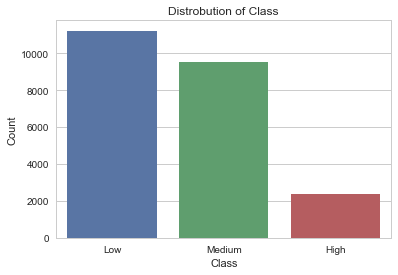

In [25]:
graph = df.groupby(['Class'])['LogScore'].count().reset_index()
graph.columns = ['Class','Count']
sns.set_style("whitegrid")
ax = sns.barplot(x = 'Class', y = 'Count', data=graph, order=['Low', 'Medium', 'High'])
ax.set(xlabel='Class', ylabel= 'Count', title = 'Distrobution of Class')
graph

In [26]:
df['PostLength'] = df['title'].str.len()

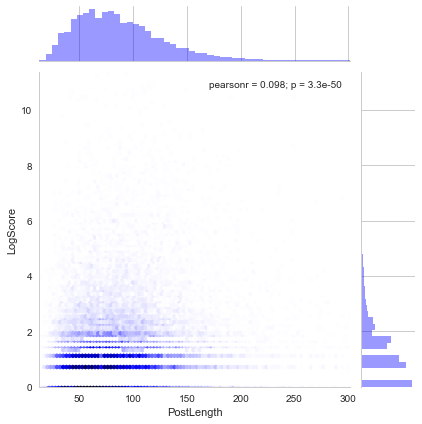

In [27]:
sns.jointplot(x='PostLength', y="LogScore", data=df, kind="hex", color="blue");

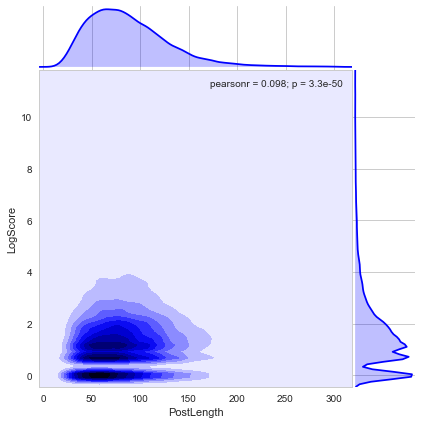

In [28]:
sns.jointplot(x='PostLength', y="LogScore", data=df, kind="kde", space=0, color="blue");

We can see that Shorter ones tend to score higher. 

# Machine Learning

We have most of the features that we might need. Now we should split the data into the dependent and independant variables and split both of those into train and test.

In [29]:
X = df.drop(['score', 'created_utc', '_id', 'LogScore', 'Class'], axis=1)

#del X[['score', 'created_utc', '_id', 'Time', 'DoW', 'LogScore', 'Class']]
X.head()

,title,Time,DoW,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,1,...,15,16,17,18,19,20,21,22,23,PostLength
0,Napkins are reverse toilet paper,19,Saturday,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,32
1,"Evolution of Squirrels, etc...",19,Saturday,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,30
2,One day enough time will have passed that we k...,19,Saturday,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,108
3,"Why do we drink, drinks yet we eat food.",19,Saturday,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,40
4,Kevin Spacey's personality is starting to look...,19,Saturday,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,84


In [30]:
 
X['title1'] = df.title+ ' ' + df.DoW.map(str) + " " + 'H'+ df.Time.map(str) + ' ' + 'Len'+ df.PostLength.map(str)

In [31]:
X = X[['title1']]

In [32]:
y = df['Class']
y.head()


0    Medium
1       Low
2       Low
3       Low
4       Low
Name: Class, dtype: object

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [35]:
X_train.head()

,title1
11062,"In Romeo and Juliet's time, wouldn't Romeo hav..."
6329,Some saddles are made out of horseh_ide and th...
12365,Why do we tell humans to shut up but computers...
17730,"""YW"" is kind of cheesy in an email, but infini..."
6947,The first beep on a smoke detector should be r...


In [36]:
y_test.head()

18795       Low
19305    Medium
8642     Medium
8316     Medium
15862       Low
Name: Class, dtype: object

## Naive Bayse:
This example was addapted from the [sklearn](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html) documentation.

In [37]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(stop_words = 'english')
X_train_counts = count_vect.fit_transform(X_train['title1'])
X_train_counts.shape

(15485, 17166)

In [38]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape

(15485, 17166)

In [39]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(15485, 17166)

Let's try with only the words:

In [42]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [43]:
docs_new = ["We miss one Zanzibar hundred percent of the shots we don't take", 'Nobody thinks in the shower']
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

clf.predict(X_new_tfidf)


array(['Low', 'Low'],
      dtype='<U6')

Apparently I'm not very funny.

In [45]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer(stop_words = 'english')),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
])

In [47]:
text_clf.fit(X_train.title1, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        ...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [49]:
docs_new = X_test['title1']
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)

In [50]:
docs_new.head()

18795    It takes 3.91 years to become a drunk. Sunday ...
19305    there should be one anonymous throw away accou...
8642     If you rip lace it will have fewer holes than ...
8316     Potassium cyan_ide is medicine equivalent of A...
15862    Someone should make a gif where one person dra...
Name: title1, dtype: object

In [51]:
predicted

array(['Low', 'Low', 'Low', ..., 'Low', 'Medium', 'Low'],
      dtype='<U6')

In [52]:
np.mean(predicted == y_test)

0.48013635767667495

Well that number isn't very good. Let's compare it to random guessing:

In [53]:
y_train = y_train.to_frame(name = 'Class')
y_train.reset_index()
y_train['Zeros'] = 0
percentC = y_train.groupby('Class').count()

In [54]:
count = len(y_train)
perHigh = percentC.Zeros['High']/count
perMedium = percentC.Zeros['Medium']/count
perLow = percentC.Zeros['Low']/count

In [55]:
from numpy.random import choice
randomGuess = choice(["High", 'Medium', 'Low'], len(y_test), [perHigh, perMedium, perLow])

In [56]:
np.mean(randomGuess == y_test)

0.32856955552641931

In [57]:
print("We outperfromed random guessing by:", (np.mean(predicted == y_test) - np.mean(randomGuess == y_test)) * 100, '%')

We outperfromed random guessing by: 15.156680215 %


Unfortunetly:

In [58]:
allLow = choice(["Low"], len(y_test), 1)

In [59]:
print("We underperfored guessing all low by:", (np.mean(predicted == y_test) - np.mean(allLow == y_test)) * 100, '%')

We underperfored guessing all low by: -1.11446178052 %


In [60]:
from sklearn import metrics
print(metrics.classification_report(y_test, predicted))

             precision    recall  f1-score   support

       High       0.00      0.00      0.00       764
        Low       0.50      0.73      0.59      3747
     Medium       0.43      0.30      0.35      3116

avg / total       0.42      0.48      0.44      7627



/Applications/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Let's see if we can do better with different algorithms.

In [73]:
from sklearn.linear_model import SGDClassifier
text_clf = Pipeline([('vect', CountVectorizer(stop_words = 'english')),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                           alpha=1e-3, random_state=42,
                                           max_iter=5, tol=None)),
])
text_clf.fit(X_train.title1, y_train.Class)  

predicted = text_clf.predict(X_test.title1)
np.mean(predicted == y_test)    

0.49246099383768194

In [74]:
print("We outperfromed random guessing by:", (np.mean(predicted == y_test) - np.mean(randomGuess == y_test)) * 100, '%')

We outperfromed random guessing by: 16.3891438311 %


We achieve slightly better performance here. It is still not inspiring. 

In [81]:
print(metrics.classification_report(y_test, predicted))

             precision    recall  f1-score   support

       High       0.00      0.00      0.00       764
        Low       0.50      0.89      0.64      3747
     Medium       0.45      0.14      0.21      3116

avg / total       0.43      0.49      0.40      7627



In [82]:
y_train['Cat'] = 0
y_train.loc[df['Class'] == 'Low', 'Cat'] = 1
y_train.loc[df['Class'] == 'Medium', 'Cat'] = 2
y_train.loc[df['Class'] == 'High', 'Cat'] = '3'
y_array = y_train.Cat.as_matrix
#y_array = np.array(y_array)
y_array = y_train['Cat']

In [83]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(7500,), random_state=1)

In [1]:
#clf.fit(X_train_tfidf, y_train.Class)

My neural net took too long to train. It would be nice to look at in the future, but I'd have to set up an docker image on AWS and spend some money crunching these variables. 

# Recap:
This analysis was slightly dissapointing because we didn't get great results. Also, if I had had more time, I would have tried to scrape more info including more highly rated comments. As it is, I still think the analysis is kind of cool and taught me a lot. 